downloading the sample ground truth...
visualizing ground truth annotation on the sample image...


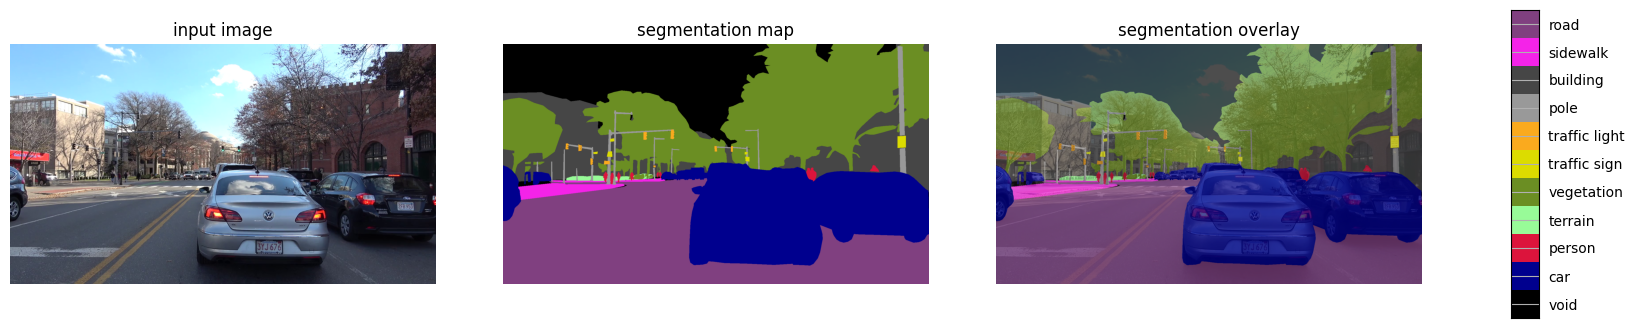

evaluating on the sample image...
pixel accuracy: 0.90720
mean class IoU: 0.5383739999999999
class IoU:
   road    sidewalk    building     pole    traffic light    traffic sign    vegetation    terrain    person     car
-------  ----------  ----------  -------  ---------------  --------------  ------------  ---------  --------  ------
0.96126     0.34571     0.52489  0.16418          0.49512         0.52207       0.82085    0.05721   0.52215  0.9703
evaluating on the sample video...


100%|██████████| 30/30 [04:09<00:00,  8.31s/it]

pixel accuracy: 0.8995
mean class IoU: 0.5276
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9554      0.4104      0.5283  0.1594           0.4487          0.5508        0.8295     0.0474    0.3879  0.9582
evaluating on the sample video with temporal smoothing...



100%|██████████| 30/30 [04:08<00:00,  8.27s/it]

pixel accuracy: 0.8998
mean class IoU: 0.5284
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9554      0.4064      0.5285   0.158           0.4504           0.551        0.8297     0.0453    0.4008  0.9586


In [ ]:

import tensorflow as tf
print(tf.__version__)
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import warnings
warnings.simplefilter("ignore", DeprecationWarning)


class segmentation_scene(object):


    fgn = 'frozen_inference_graph'

    def __init__(self, tar_path):
        #Creates and loads pretrained deeplab model
        self.graph = tf.Graph()
        graph_def = None

        #extract from .tar file
        tar_f = tarfile.open(tar_path)
        for info_t in tar_f.getmembers():
            if self.fgn in os.path.basename(info_t.name):
                file_h = tar_f.extractfile(info_t)
                graph_def = tf.GraphDef.FromString(file_h.read())
                break
        tar_f.close()

        if graph_def is None:
            raise runtimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):

        width, height = image.size
        size = (2049,1025)
        resized_img = image.convert('RGB').resize(size, Image.ANTIALIAS)
        bsm = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_img)]})
        sm = bsm[0]
        if len(sm.shape) == 2:
            sm = np.expand_dims(sm,-1)
        sm = cv.resize(sm, (width,height), interpolation=cv.INTER_NEAREST)
        return sm



#create labels and visualize
def colormap_creation():

    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_color_img(label):

    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = colormap_creation()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def visual_seg(image, sm):

    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_color_img(sm).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_lbs = np.unique(sm)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(full_clr_map[unique_lbs].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_lbs)), labels[unique_lbs])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


labels = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

full_lbl_map = np.arange(len(labels)).reshape(len(labels), 1)
full_clr_map = label_color_img(full_lbl_map)

#model
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
model = 'mobilenetv2_coco_cityscapes_trainfine'


_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_directory = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_directory)

download_path = os.path.join(model_directory, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[model], download_path)
print('download completed! loading DeepLab model...')

MODEL = segmentation_scene(download_path)
print('model loaded successfully!')



smp_img = 'mit_driveseg_sample.png'
if not os.path.isfile(smp_img):
    print('downloading the sample image...')
    smp_img = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.png?raw=true')[0]
print('running deeplab on the sample image...')

def run_viz(smp_img):

    org_img = Image.open(smp_img)
    sm = MODEL.run(org_img)
    visual_seg(org_img, sm)

run_viz(smp_img)




def viz_seg_s(image, sm, index):

    plt.figure(figsize=(12, 7))

    seg_image = label_color_img(sm).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay | frame #%d'%index)
    plt.grid('off')
    plt.tight_layout()


    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()


def run_viz_video(frame, index):

    org_img = Image.fromarray(frame[..., ::-1])
    sm = MODEL.run(org_img)
    viz_seg_s(org_img, sm, index)


SAMPLE_VIDEO = 'mit_driveseg_sample.mp4'
if not os.path.isfile(SAMPLE_VIDEO):
    print('downloading the sample video...')
    SAMPLE_VIDEO = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4')[0]
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)

num_frames = 30

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        run_viz_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")




class DriveSeg(object):


    def __init__(self, tar_path):
        self.tar_f = tarfile.open(tar_path)
        self.info_t = self.tar_f.getmembers()

    def fetch(self, index):

        info_t = self.info_t[index + 1]
        file_h = self.tar_f.extractfile(info_t)
        gt = np.fromstring(file_h.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]
        gt[gt==255] = 19
        return gt


SAMPLE_GT = 'mit_driveseg_SAMPLE_GT.tar.gz'
if not os.path.isfile(SAMPLE_GT):
    print('downloading the sample ground truth...')
    SAMPLE_GT = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample_gt.tar.gz')[0]

dataset = DriveSeg(SAMPLE_GT)
print('visualizing ground truth annotation on the sample image...')

org_img = Image.open(smp_img)
gt = dataset.fetch(0)
visual_seg(org_img, gt)




def eval_img(sm, ground_truth):


    sm[np.logical_or(sm==14,sm==15)] = 13
    sm[np.logical_or(sm==3,sm==4)] = 2
    sm[sm==12] = 11


    acc = np.sum(sm[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)


    cm = confusion_matrix(ground_truth[ground_truth!=19], sm[ground_truth!=19],
                          labels=np.array([0,1,2,5,6,7,8,9,11,13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)
    return acc, intersection, union


print('evaluating on the sample image...')

org_img = Image.open(smp_img)
sm = MODEL.run(org_img)
gt = dataset.fetch(0)  # sample image is frame 0
acc, intersection, union = eval_img(sm, gt)
class_intesectionoverunion = np.round(intersection / union, 5)
print('pixel accuracy: %.5f'%acc)
print('mean class IoU:', np.mean(class_intesectionoverunion))
print('class IoU:')
print(tabulate([class_intesectionoverunion], headers=labels[[0,1,2,5,6,7,8,9,11,13]]))



print('evaluating on the sample video...', flush=True)

video = cv.VideoCapture(SAMPLE_VIDEO)
num_frames = 30

acc = []
intersection = []
union = []

for i in tqdm(range(num_frames)):
    _, frame = video.read()
    org_img = Image.fromarray(frame[..., ::-1])
    sm = MODEL.run(org_img)
    gt = dataset.fetch(i)
    _acc, _intersection, _union = eval_img(sm, gt)
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)

class_intesectionoverunion = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('pixel accuracy: %.4f'%np.mean(acc))
print('mean class IoU: %.4f'%np.mean(class_intesectionoverunion))
print('class IoU:')
print(tabulate([class_intesectionoverunion], headers=labels[[0,1,2,5,6,7,8,9,11,13]]))







print('evaluating on the sample video with temporal smoothing...', flush=True)

video = cv.VideoCapture(SAMPLE_VIDEO)
num_frames = 30

acc = []
intersection = []
union = []
prev_sm_logits = 0

for i in tqdm(range(num_frames)):
    _, frame = video.read()
    org_img = Image.fromarray(frame[..., ::-1])


    sm_logits = MODEL.run(org_img, OUTPUT_TENSOR_NAME='ResizeBilinear_3:0')


    sm = np.argmax(sm_logits + prev_sm_logits, -1)
    prev_sm_logits = sm_logits

    gt = dataset.fetch(i)
    _acc, _intersection, _union = eval_img(sm, gt)
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)

class_intesectionoverunion = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('pixel accuracy: %.4f'%np.mean(acc))
print('mean class IoU: %.4f'%np.mean(class_intesectionoverunion))
print('class IoU:')
print(tabulate([class_intesectionoverunion], headers=labels[[0,1,2,5,6,7,8,9,11,13]]))